# Advanced Machine Learning 2024/2025

##  PROJECT 2: (Deep) Reinforcement Learning

&copy;Helton Mendonça, nº56870 and &copy;Inês Veloso, nº56884

Supervised and evaluated by Professor Helena Aidos



### 1. Objective

---


In this second project of the Advanced Machine Learning course, we are challenged with implementing (Deep) Reinforcment Learning techniques to solve the MountaiCar problem.

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import gymnasium as gym
import jax
import gymnax
import jax.numpy as jnp
import time
from RLinJAX import *

### 2. Preparing the enviroment
---


#### 2.1 Exploring the enviroment

From analysing the page of mountain car we know that the model consists of a car placed stochastically at the bottom of a sinusoidal valley, with the objective of getting to the top of the mountain at the right.The environment will have 3 parameters:

*  **State:** A continuous space that has the position of the car and the velocity of it. 0 is the position of the car along the x-axis and 1 is the velocity of the car;
*  **Action:** An action that the agent can perform in each state, and its discreet. Exists three possible actions: accelerating to the left (0), staying on the same spot (1) and accelarating to the right (2);
*  **Reward function:** will be further exlained in Q-learning secion.

In [62]:
env_name = 'MountainCar-v0'
env = gym.make(env_name, render_mode='rgb_array')

In [63]:
print(env.observation_space.shape)
print(env.action_space)

(2,)
Discrete(3)


The code below will give us the environment space, and the first argument will be the observation low and the second argument the observation high. And the position is
clipped to the range [-1.2, 0.6] and velocity is clipped to the range [-0.07, 0.07].

In [64]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

As stated in the documentation the goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of -1 for each timestep.

In the documentation the episode will end given two options: the car will get to the top of the right hill equal to 0.5, or the lenght of the episode is 200.

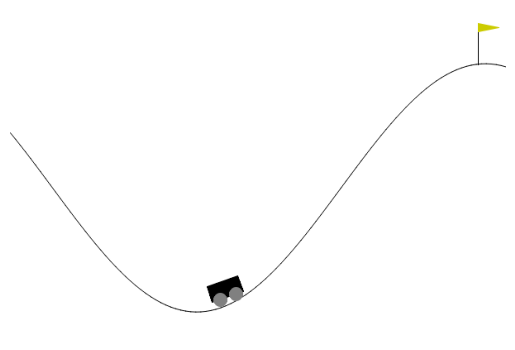

In [65]:
env.reset()
plt.imshow(env.render())
plt.axis('off')
plt.show()

#### 2.2 Discretizing the space domain

As said previously, the environment has continuous variables, and the Q-Learning algorithm is only capable of dealing with discreet variables, therefore whe have to discretize our state space. We have to choose the number of bins carefuully, since a large number can make it computationally expensive and slow, and a low number might not be able to capture the details of the variables.

In [66]:
import numpy as np
def discretize_state(current_state,bins):
  discretized_state = (current_state-env.observation_space.low)/(env.observation_space.high-env.observation_space.low)*(bins)
  discretized_state = discretized_state.astype(int)
  return discretized_state

### 3. Implementing the Agents

### 3.1 Q-learning


##### Reinforcement Learning

Reinforcement learning (RL) is an interdisciplinary area of machine learning that adresses the problem of finding suuitable actions to take in a given situation in order to maximize the rewards. In contrast to supervised learning , the algorithm isn't provided with examples of optimal outputs, it has to learn via trial and error. In some cases the current action not only affects the immediate reward, but also has an impact on the reward at all subsequent time steps (for exemple, let's take chess as an example, if we make a move, the future moves rewards will be affected by the previous move, since if we make a really good move the next ones may have a better chance of checkmating).


We can describe a RL problem as a system with an agent and an environment. In which a **state** is the information that describes the state of the environment. An **agent** interacts with the environment by observing it and chosing an **action**. Then, the environment will transition to the next state and gives a reward and a state to the agent. This cycle will be repeated until the problem is solved. An example of this interaction is seen below:

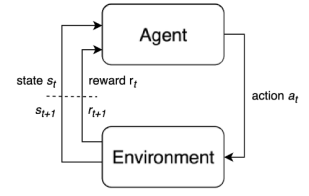

In reinforcement learning, an algorithm can be on-policy or off-policy. A policy consists on the way an agent behaves at a given moment. And the distinction between on-policy and off-policy methods lies in the relationship between the policy used to generate behaviour (behaviour policy) and the policy being evaluated and improved (target policy).

In on-policy methods, the behaviour policy and the target policy are the same. The **agent learns about the policy it is using to make decisions**. This means that the agent is exploring and learning from the same policy. Even though this mode is, generally, more simple and more stavle, it can be less efficient since it can get stuck in local maxima.

In off-policy the behaviour policy and the target policy are different. The **agent learns about a different policy to the one it is using to generate behaviour**. This can lead to faster convergence towards an optimal policy. Contrary to on-policy it won't get stuck on local maxima, and is more powerfull and complex than the previous.

For this work we will be using off-policy methods, the first will be Q-learning.

Q-learning is an algoithm that seeks to learn the optimal action value function (optimal function), denoted by Q(s,a). It represents, the expected long-term reward that an agent receives by taking a specific action (a) in a given state (s). It learns the optimal policy by updating the action value estimates using the difference between the expected reward and the observed reward. As explained previously it's model-free which means it doesn't require to know the state transition probabilities or rewards in advance, and it
adapts well to dynamic environments, with well adjusted learning rates ($α$) and exploration rates($ϵ$). These parameters are responsible for making a algorithm work.

The equation used for Q-learning is the following:

$ Q(S, A) = Q(S, A) + α [r + γ maxₐ Q(S', a) - Q(S, A)] $


In which:

*  $Q(S, A)$: Current action value for state S and action A.
*  $α$: Learning rate, it controlls the speed of the update. If it's high, then it adapts more quickly to new information, learning faster but being more unstable. On another hand, if the value is low, then it takes smaller steps and is more cautious when taking into consideration new knowledge, but it's more stable. Therefore we need to find a value low enough that is stable and cautious, but high enough that is able to eventually converge.
*  $r$: Reward received.
*  $γ$: Discount factor, it's the importance we give to future rewards, it's how much the agent valorizes the imediate reward, in comparison to future rewards. If we increase the discount factor, it means that we favour the future, and if we decrease it, it means that we give more importance to immediate rewards.
*  $S'$: New state after taking action A.
*  $maxₐQ(S', a)$: Estimativa do valor máximo de ação possível no estado S'.

It can learn about the optimal policy, even if we use a different exploitation policy, such as ε-greedy policy. In Q-learning, the ε-greedy policy is a strategy that tries to achieve a balance between: exploration (trying new actions to discover their rewards) and exploitation (choosing actions known to yield the highest rewards based on current knowledge). A small ε means that the agent performs a random action (exploration), and the remaining probability, 1 - ε, the agent selects the action with the highest Q-value for the current state (exploitation). 

It's important for an agent to explore in the early stages of learning and focus on explotation in the latter states of learning, since as the agent explores it obtains better optimal values for the Q-table, and as the Q-table achives optimal values the agent can focus on maximizing rewards in short term.

In [67]:
def epsilon_greedy(position, velocity, epsilon):
    number = random.uniform(0, 1)

    if number < epsilon:
      action = env.action_space.sample()
    else:
      action = np.argmax(Q_table[position][velocity])

    return action

For the parameters we tried different values to see which gave us the best results. Firstly, we tried using different bins, we tried {10,20,30}, when we used 30 we found that it would converge, however it took around 177 minutes to run the code. For bins=20, we were also able to achieve convergence but it took around  165 minutes. If we use bins= 10 we were also able to achieve convergence however it takes 156 minutes. As we can see in the results bellow, we were able to achieve convergence with all the different values, however when using bias of 10 the code took less time to achieve the same results of the other bias, the only difference is that when we used bins = 20 we were able to obtain a litle better average rewards, but we choose to use a less heavy algorithm.

![Average reward with bias=10.png](<attachment:Average reward with bias=10.png>)


![Average reward with bias=20.png](<attachment:Average reward with bias=20.png>)


![Average reward with bias=30.png](<attachment:Average reward with bias=30.png>)

For the discount factor (gamma)we choose 0.9 since, given the exercise we should value more the final result than valuing the immediate rewards, since our objective is to get to the end in the least ammount of steps. Lastly for the learning rate (0.1) as said before, should have a value low enough that is stable and cautious, but high enough that is able to eventually converge. Therefore we tried {0.05,0.1,0.2}, while using the bias = 10 and what we verified is that with a lower learning rate, it took less time to converge, and the it had higher average rewards.

**Average reward with lr=0.05.png:**

![Average reward with lr=0.05.png](<attachment:Average reward with lr=0.05.png>)


**Average reward with lr=0.1.png:**

![Average reward with bias=10.png](<attachment:Average reward with bias=10.png>)


**Average reward with lr=0.2.png:**


![Average reward with lr=0.2.png](<attachment:Average reward with lr=0.2.png>)

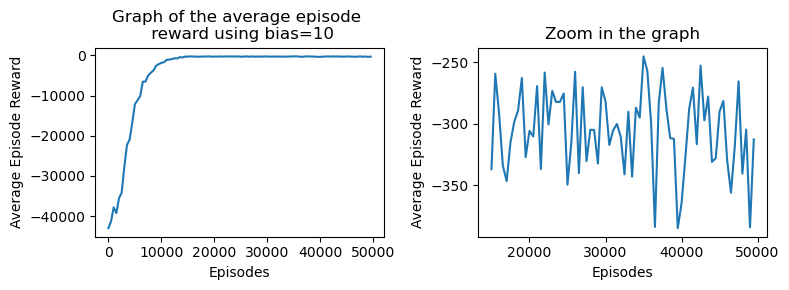
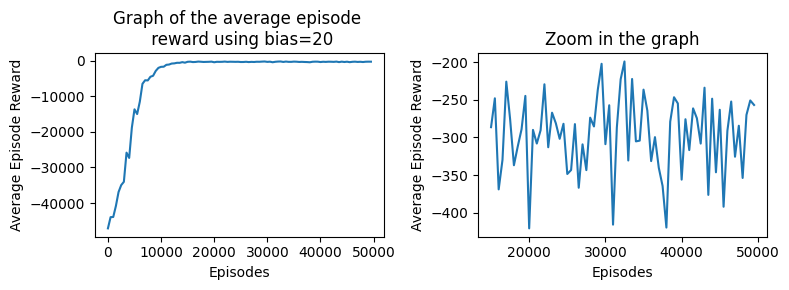
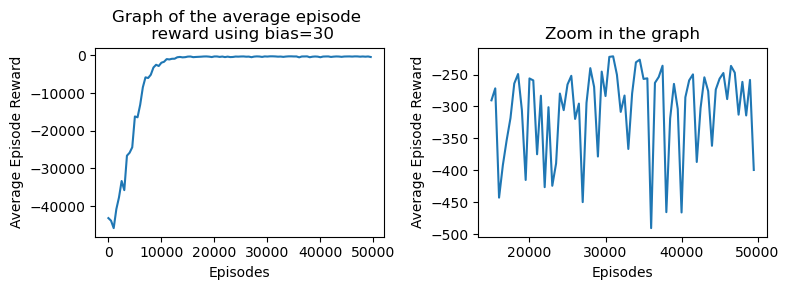
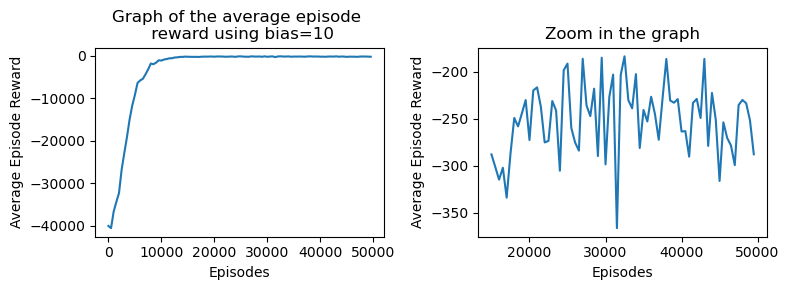
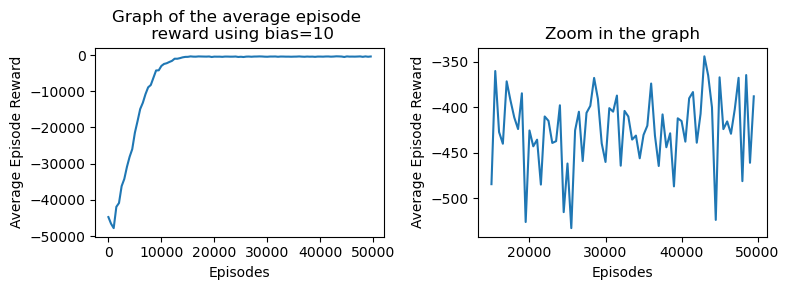

In [86]:
bins = 10
Q_table = np.zeros((bins, bins, env.action_space.n)) # Table of actions per state

In [87]:
#Parameter definition
num_episodes = 50000
epsilon = 0.95
reduction = 3/num_episodes
gamma = 0.9
alpha = 0.05
num_steps = 500                                                                             #we tried using 200, as said for the exercise, however it doesn't converge, therefore we
                                                                                            #need to make it higher or do a while cycle
total_rewards = []
block_reward = []
avg_total_rewards = []
reward_ep = []
ep_lenght = []

In [88]:
#for each episode:
for i in range(num_episodes):

    #initialize the state by resetting the environment
    s,_ = env.reset()
    disc_s = discretize_state(s, bins)
    p = disc_s[0]
    v = disc_s[1]                                                                           #Should be 0 in the beggining
    episode_r = 0
    lenght = 0
    done = False


    #for each step in the episode
    while done == False:                                                                     #if we dont do while, it doesnt converge,

        a = epsilon_greedy(p, v, epsilon)                                                    #select the action using the epsilon-greedy policy
        s_, r, done, _, _ = env.step(a)                                                      #perform the selected action and store the next state information
        disc_s_ = discretize_state(s, bins)                                                   #we have to discretize our next state again

        p_ = disc_s_[0]
        v_ = disc_s_[1]

        a_ = np.argmax([Q_table[(p_, v_, a)] for a in range(env.action_space.n)])             #we select the action a dash which has a maximum Q value in the next state

        if done:
          Q_table[p, v, a] = r
          break

        else:
          Q_table[p][v][a] = Q_table[p][v][a] + alpha*(r + gamma*Q_table[p_][v_][a_] - Q_table[p][v][a])      #we calculate the Q value of previous state using our update rule


        #update current state to next state
        s = s_
        episode_r += r
        p = p_
        v = v_
        lenght += 1


    epsilon = max(epsilon-reduction, 0.05)  #epsilon decay
    reward_ep.append(episode_r)
    ep_lenght.append(lenght)
    
    if (i+1)%500 == 0:  #compute average rewards for each 500 episodes
        avg_total_rewards.append(np.mean(block_reward))
        print('The average reward per episode from episode %i to episode %i was %.2f' %(i+1-500, i, np.mean(block_reward)))
        block_reward = []
    else:
        block_reward.append(episode_r)

    total_rewards.append(episode_r)

env.close()

The average reward per episode from episode 0 to episode 499 was -41559.85
The average reward per episode from episode 500 to episode 999 was -38500.06
The average reward per episode from episode 1000 to episode 1499 was -41024.85
The average reward per episode from episode 1500 to episode 1999 was -36395.52
The average reward per episode from episode 2000 to episode 2499 was -31032.62
The average reward per episode from episode 2500 to episode 2999 was -30057.72
The average reward per episode from episode 3000 to episode 3499 was -21646.61
The average reward per episode from episode 3500 to episode 3999 was -18967.71
The average reward per episode from episode 4000 to episode 4499 was -14857.07
The average reward per episode from episode 4500 to episode 4999 was -11845.21
The average reward per episode from episode 5000 to episode 5499 was -8707.30
The average reward per episode from episode 5500 to episode 5999 was -7632.97
The average reward per episode from episode 6000 to episode 

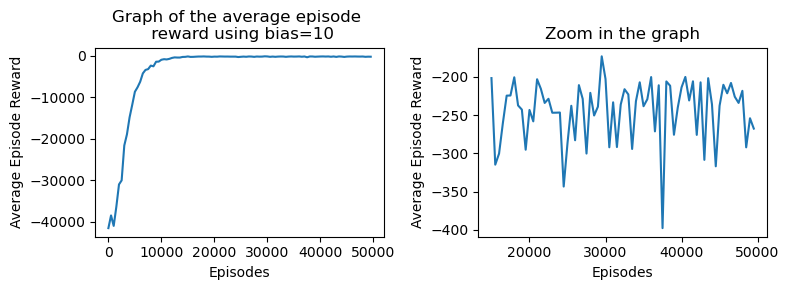

In [89]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(range(0, 50000, 500), avg_total_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Episode Reward')
plt.title ("Graph of the average episode \n reward using bias=%i" %(bins))

plt.subplot(1, 2, 2)
plt.plot(range(15000, 50000, 500), avg_total_rewards[30:])
plt.xlabel('Episodes')
plt.ylabel('Average Episode Reward')
plt.title ("Zoom in the graph")

plt.tight_layout()
plt.show()

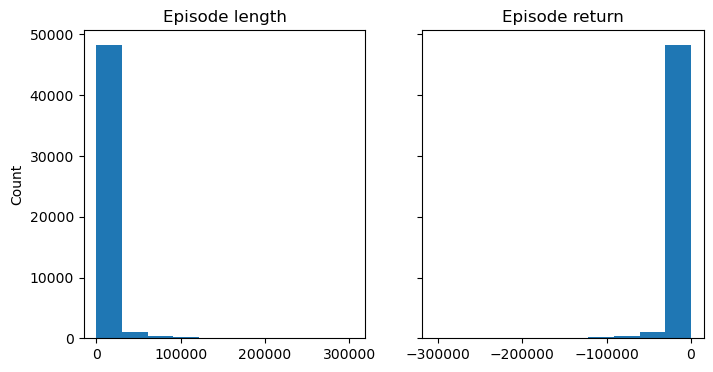

In [124]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharey="row")

plt.title("Evaluation for (our) best policy")
axes[0].hist(ep_lenght, bins=10)
axes[0].set(title="Episode length", ylabel="Count")
# axes[0].set_xticks(range(100, 210, 10))
axes[1].hist(reward_ep, bins=10)
axes[1].set(title="Episode return")
plt.show()

In [119]:
# Define thresholds for "shorter episodes" and "higher rewards"
short_episode_threshold = 125  # Episodes shorter than 125 steps
high_reward_threshold = -125  # Rewards higher than -125
steps_to_flag = 200 
short_episodes_count = 0
high_rewards_count =0
steps_count = 0

# Calculate percentages
total_episodes = len(ep_lenght)
for i in range(0,total_episodes):
    if ep_lenght[i]< short_episode_threshold:
        short_episodes_count += 1

for i in range(0,total_episodes):
    if reward_ep[i]> high_reward_threshold:
        high_rewards_count += 1
    
for i in range(0,total_episodes):
    if ep_lenght[i]< steps_to_flag:
        steps_count += 1

short_episodes_percentage = (short_episodes_count / total_episodes) * 100
high_rewards_percentage = (high_rewards_count / total_episodes) * 100
steps_count_percentage = (steps_count / total_episodes) * 100


print('Short episodes percentage',short_episodes_percentage, '%')
print('High rewards percentage',high_rewards_percentage,"%")
print('Cart finished in less than 200 steps percentage',steps_count_percentage,"%")


Short episodes percentage 0.438 %
High rewards percentage 0.438 %
Cart finished in less than 200 steps percentage 37.284 %


In [98]:
# Calculate average returns
average_return = np.mean(reward_ep)

# Calculate the standard deviation of returns
std_deviation = np.std(reward_ep)

# Count the occurrences of each return value as percentages
unique_returns, return_counts = np.unique(reward_ep, return_counts=True)
return_percentages = (return_counts / len(reward_ep)) * 100

print(f"Average return and Standard deviation: {average_return} +/- {std_deviation}")

Average return and Standard deviation: -3508.36008 +/- 13906.524517734197


#### 3.2 Deep Q-learning

In the previous section we discretised the states so that we could use Q-learning. However, this method is not always the most suitable because the sheer volume of possible states and actions leads to an impractical Q-table in real-world applications. In this occasions we may need to find another solution, one with powerful function approximation algorithms, such as the Neural Network.

Deep Q-learning is a reinforcement learning algorithm that combines Q-learning with deep neural networks. Neural nets are used as a replacement for the Q-table and provide an efficient solution to the curse of dimensionality introduced by large state spaces. This combination allows agents to learn control policies directly from high-dimensional data. It has the pros of: Handling High-Dimensional Inputs; Learning Complex Policies; Generalization Across Tasks; Scalability; Exploration and Adaptation; End-to-End Learning.

DQN uses two neural networks in parallel, one is an "online" network responsible for predicting the Q-value and decision-making, whereas, the "target" network is responsible for creating stable Q-targets to assess the performance of the online net via the loss function.

##### Act

The act function defines how the agent chooses actions. It implements an epsilon-greedy policy in relation to the Q values estimated by the online neural network. The agent selects the action with the highest predicted Q value for a given state, but there is also a chance to act randomly to explore the environment.

Unlike traditional Q-learning, which updates its Q table at every step, DQN uses gradient descent on a batch of data to train the neural network. To do this, it stores the agent's experiences (tuples containing ‘state’, ‘action’, ‘reward’, ‘next state’, ‘end signalling’) in a replay buffer.

##### Update

The update function is responsible for training the network. It calculates the mean square error (MSE) based on the time difference error (TD), as shown in the equation:

$$L(\theta)=E\left[ (r+(1-done) \times \gamma \max_{a'} Q(s‘,a’;\theta^-) - Q(s,a;\theta))^2 \right]$$

In this loss function:
*  $\theta$ represents the parameters of the online network.
*  $\theta^-$ represents the parameters of the target network.

The parameters of the target network are copied from the online network every $N$ steps, acting as a ‘checkpoint’. This separation of parameters is essential to stabilise the training. If the same parameters were used for both networks, updates to the online network would immediately change the target values, making learning unstable. By periodically updating $\theta^-$ (freezing these parameters for a set number of steps), we guarantee stable Q targets while the online network continues to learn.

Finally, the $(1-done)$ term adjusts the target for terminal states. When an episode ends (‘done’ equals 1), there is no next state and the Q value for the next state is set to 0.
This dual-network architecture and the use of a replay buffer allow DQN to learn more stably and efficiently from a set of experiences, rather than just the most recent experience.

##### Replay Buffers

Replay buffers are widely used in Deep Reinforcement Learning, since they offer several advantages:
*  Generalisation: It breaks the correlation between consecutive trials, preventing the model from over-fitting and promoting a better generalisation capacity.
*  Diversity: Samples covers a wider range of experiences, which contributes to less variance in updates and prevents overspecialisation in recent experiments.
*  Increased Sampling Efficiency: The experiences stored in the buffer can be sampled multiple times, allowing the model to extract more knowledge from each individual experience, optimising the use of the available data.




##### **Defining the Environment and Settings**


In [2]:
rng = jax.random.PRNGKey(0)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)
env, env_params = gymnax.make("MountainCar-v0")

In [3]:
CONFIGS = {"dqn":{"agent": "DuelingQNetwork",
                  "agent_kwargs": {"activation": "swish"},
                  "num_envs": 10,
                  "buffer_size": 100_000,
                  "fill_buffer": 1_000,
                  "batch_size": 100,
                  "learning_rate": 0.0003,
                  "polyak": 0.98,
                  "num_epochs": 5,
                  "target_update_freq": 200,
                  "total_timesteps": 100_000,
                  "eval_freq": 5000,
                  "eps_start": 1,
                  "eps_end": 0.01,
                  "exploration_fraction": 0.5,
                  "gamma": 0.9,
                  "ddqn": True
                 },
           "sac": {
                  "agent_kwargs": {"activation": "relu"},
                  "num_envs": 10,
                  "buffer_size": 100_000,
                  "fill_buffer": 1_000,
                  "batch_size": 100,
                  "learning_rate": 0.0003,
                  "polyak": 0.98,
                  "num_epochs": 5,
                  "target_update_freq": 200,
                  "total_timesteps": 100_000,
                  "eval_freq": 5000,
                  "gamma": 0.9,
                  "target_entropy_ratio": 0.98,
                  "num_critics": 2,

          }

}

In [4]:
algo_str = "dqn"
env_str = 'MountainCar-v0'

algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))
algo.config

{'env': <gymnax.environments.classic_control.mountain_car.MountainCar at 0x1be596a4aa0>,
 'env_params': {'max_steps_in_episode': 200,
  'min_position': -1.2,
  'max_position': 0.6,
  'max_speed': 0.07,
  'goal_position': 0.5,
  'goal_velocity': 0.0,
  'force': 0.001,
  'gravity': 0.0025},
 'eval_callback': <function RLinJAX.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 5000,
 'skip_initial_evaluation': False,
 'total_timesteps': 100000,
 'learning_rate': 0.0003,
 'gamma': 0.9,
 'max_grad_norm': inf,
 'normalize_observations': False,
 'target_update_freq': 200,
 'polyak': 0.98,
 'num_envs': 10,
 'buffer_size': 100000,
 'fill_buffer': 1000,
 'batch_size': 100,
 'eps_start': 1,
 'eps_end': 0.01,
 'exploration_fraction': 0.5,
 'agent': {'hidden_layer_sizes': (64, 64),
  'activation': <PjitFunction>,
  'action_dim': 3,
  'parent': None,
  'name': None},
 'num_epochs': 5,
 'ddqn': True}

##### **Replacing some of the settings**

In [5]:
algo = algo.replace(gamma=0.99)
algo = algo.replace(batch_size = 256)
algo = algo.replace( total_timesteps = 1_000_000)
algo = algo.replace( buffer_size = 250_000)
algo = algo.replace(target_update_freq = 800)
algo = algo.replace(exploration_fraction = 0.6)
algo = algo.replace(eps_end = 0.05)



print(f"New gamma: {algo.gamma}")
print(f"New batch size: {algo.batch_size}")
print(f"New total timesteps: {algo.total_timesteps}")
print(f"New buffer size: {algo.buffer_size}")
print(f"New learning rate: {algo.learning_rate}")
print(f"New target update freq: {algo.target_update_freq}")
print(f"New exploration fraction: {algo.exploration_fraction}")
print(f"New eps end: {algo.eps_end}")

# New parameters
algo.config

New gamma: 0.99
New batch size: 256
New total timesteps: 1000000
New buffer size: 250000
New learning rate: 0.0003
New target update freq: 800
New exploration fraction: 0.6
New eps end: 0.05


{'env': <gymnax.environments.classic_control.mountain_car.MountainCar at 0x1be596a4b60>,
 'env_params': {'max_steps_in_episode': 200,
  'min_position': -1.2,
  'max_position': 0.6,
  'max_speed': 0.07,
  'goal_position': 0.5,
  'goal_velocity': 0.0,
  'force': 0.001,
  'gravity': 0.0025},
 'eval_callback': <function RLinJAX.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 5000,
 'skip_initial_evaluation': False,
 'total_timesteps': 1000000,
 'learning_rate': 0.0003,
 'gamma': 0.99,
 'max_grad_norm': inf,
 'normalize_observations': False,
 'target_update_freq': 800,
 'polyak': 0.98,
 'num_envs': 10,
 'buffer_size': 250000,
 'fill_buffer': 1000,
 'batch_size': 256,
 'eps_start': 1,
 'eps_end': 0.05,
 'exploration_fraction': 0.6,
 'agent': {'hidden_layer_sizes': (64, 64),
  'activation': <PjitFunction>,
  'action_dim': 3,
  'parent': None,
  'name': None},
 'num_epochs': 5,
 'ddqn': True}

In [6]:
# set training seed and jit train function
rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print("Starting to train")
# Train
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train


c:\Users\helto\AppData\Local\Programs\Python\Python312\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
c:\Users\helto\AppData\Local\Programs\Python\Python312\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 3.68248 seconds (271556 steps/second).


In [7]:
print('Tuple size:', len(evaluation))
print('Episodic lengths and episodic returns shape:', evaluation[0].shape)
print(f"{algo.total_timesteps} / {algo.eval_freq} + 1 = {(algo.total_timesteps/algo.eval_freq+1)}" )

Tuple size: 2
Episodic lengths and episodic returns shape: (201, 128)
1000000 / 5000 + 1 = 201.0


In [8]:
evaluation

(Array([[200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        ...,
        [110, 110,  96, ..., 156, 112,  87],
        [142, 144, 144, ..., 113, 110, 114],
        [ 86, 113, 111, ..., 109, 108,  87]], dtype=int32, weak_type=True),
 Array([[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-110., -110.,  -96., ..., -156., -112.,  -87.],
        [-142., -144., -144., ..., -113., -110., -114.],
        [ -86., -113., -111., ..., -109., -108.,  -87.]],      dtype=float32, weak_type=True))

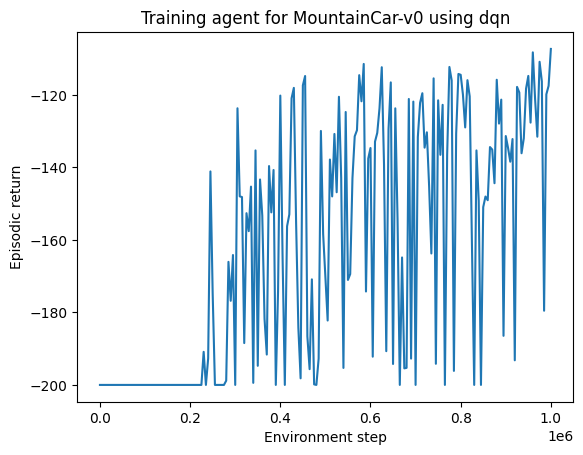

In [9]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()

In [10]:
jax.tree_util.tree_map(lambda x: x.shape, train_state).__dict__

{'rng': (2,),
 'env_state': EnvState(time=(10,), position=(10,), velocity=(10,)),
 'last_obs': (10, 2),
 'global_step': (),
 'last_done': (10,),
 'q_ts': TrainState(step=(), apply_fn=(), params={'params': {'Dense_0': {'bias': (1,), 'kernel': (64, 1)}, 'Dense_1': {'bias': (3,), 'kernel': (64, 3)}, 'MLP_0': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x000001BE59714CC0>, update=<function chain.<locals>.update_fn at 0x000001BE59715C60>), opt_state=(ScaleByAdamState(count=(), mu={'params': {'Dense_0': {'bias': (1,), 'kernel': (64, 1)}, 'Dense_1': {'bias': (3,), 'kernel': (64, 3)}, 'MLP_0': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}, nu={'params': {'Dense_0': {'bias': (1,), 'kernel': (64, 1)}, 'Dense_1': {'bias': (3,), 'kernel': (64, 3)}, 'MLP_0': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'

In [11]:
policy = algo.make_act(train_state)
policy = jax.jit(policy)

In [12]:
rng = jax.random.PRNGKey(0)
env, params = gymnax.make(env_str)
step = jax.jit(env.step)

obs, state = env.reset(rng, params)
episode_return = 0
done = False

while not done:
    rng, rng_action, rng_step = jax.random.split(rng, 3)
    action = policy(obs, rng_action)
    obs, state, reward, done, info = step(rng_step, state, action, params)
    episode_return += reward

print(f"Return achieved in one episode of {env_str}: {episode_return}")

Return achieved in one episode of MountainCar-v0: -112.0


In [13]:
from RLinJAX.evaluate import evaluate

num_seeds = 50_000
max_steps = params.max_steps_in_episode

rng = jax.random.PRNGKey(0)

start = time.time()

# Evaluation time!
episode_lengths, episode_returns = evaluate(policy, rng, env, params, num_seeds, max_steps)

time_elapsed = time.time() - start

print(
    f"Evaluated {num_seeds} episodes "
    f"with a total of {jax.numpy.sum(episode_lengths)} environment steps "
    f"in {time_elapsed:g} seconds."
)

Evaluated 50000 episodes with a total of 5415482 environment steps in 1.67574 seconds.


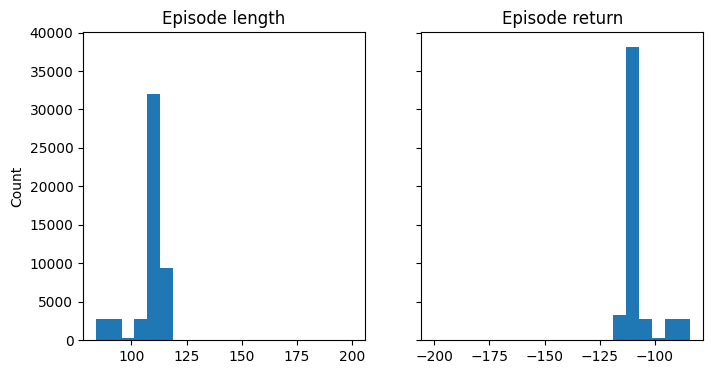

In [14]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharey="row")

plt.title("Evaluation for (our) best policy")
axes[0].hist(episode_lengths, bins=20)
axes[0].set(title="Episode length", ylabel="Count")
# axes[0].set_xticks(range(100, 210, 10))
axes[1].hist(episode_returns, bins=20)
axes[1].set(title="Episode return")
plt.show()
# axes[1].set_xticks(range(-200, -90, 10))

In [15]:
# Define thresholds for "shorter episodes" and "higher rewards"
short_episode_threshold = 125  # Episodes shorter than 125 steps
high_reward_threshold = -125  # Rewards higher than -125

# Calculate percentages
total_episodes = len(episode_lengths)
short_episodes_count = np.sum(episode_lengths < short_episode_threshold)
high_rewards_count = np.sum(episode_returns > high_reward_threshold)

short_episodes_percentage = (short_episodes_count / total_episodes) * 100
high_rewards_percentage = (high_rewards_count / total_episodes) * 100

print('Short episodes percentage',short_episodes_percentage, '%')
print('High rewards percentage',high_rewards_percentage,"%")


Short episodes percentage 99.85 %
High rewards percentage 99.85 %


In [16]:
# Calculate average returns
average_return = np.mean(episode_returns)

# Calculate the standard deviation of returns
std_deviation = np.std(episode_returns)

# Count the occurrences of each return value as percentages
unique_returns, return_counts = np.unique(episode_returns, return_counts=True)
return_percentages = (return_counts / len(episode_returns)) * 100

print(f"Average return and Standard deviation: {average_return} +/- {std_deviation}")

Average return and Standard deviation: -108.30963897705078 +/- 7.530803680419922


#### 3.3 Soft Actor-Critic


Soft Actor-Critic (SAC) is a state-of-the-art **model-free reinforcement learning algorithm** designed for continuous action spaces. It combines the benefits of **maximum entropy reinforcement learning** with an off-policy approach to improve sample efficiency and robustness.



##### Key Features
1. **Maximum Entropy Objective**:  
   SAC optimizes a stochastic policy to maximize both the expected return and the policy entropy, encouraging exploration and reducing overfitting. The objective function is:
   $$
   \pi^* = \arg\max_{\pi} \mathbb{E}_{\tau \sim \pi} \left[ \sum_{t=0}^\infty \gamma^t \big( r(s_t, a_t) + \alpha \mathcal{H}(\pi(\cdot | s_t)) \big) \right]
   $$
   where:
   -  $\mathcal{H}(\pi(\cdot | s_t))$ is the entropy of the policy at state $( s_t )$, encouraging exploration.
   - $( \alpha )$ is a temperature parameter that balances the trade-off between reward maximization and exploration.

2. **Soft Q-Function and Value Function**:  
   SAC uses the soft Q-function and value function to estimate the expected return and improve the policy. These are updated using the soft Bellman equation.

3. **Actor-Critic Framework**:
   - **Critic**: Learns the soft Q-values using a neural network and the soft Bellman residual.
   - **Actor**: Optimizes the policy by minimizing the Kullback-Leibler (KL) divergence between the current policy and a Boltzmann policy derived from the Q-values.

4. **Entropy Tuning**:  
   SAC dynamically tunes the temperature parameter  $( \alpha )$ to maintain a target entropy level, balancing exploration and exploitation.

5. **Stochastic Policies**:  
   SAC employs stochastic policies (e.g., Gaussian) to generalize better in high-dimensional environments.



##### Advantages
- **Sample Efficiency**:  
  SAC uses an off-policy approach, leveraging a replay buffer to reuse experience.
- **Stability**:  
  The use of double Q-learning helps mitigate overestimation bias.
- **Exploration**:  
  By maximizing entropy, SAC encourages diverse actions, improving exploration.


##### Applications
SAC has been widely used in tasks involving continuous control, such as robotic manipulation, locomotion, and game environments.

For more information, refer to:
- The [original SAC paper](https://arxiv.org/abs/1812.05905) by Tuomas Haarnoja et al.
- The  [discrete-action SAC](https://arxiv.org/abs/1910.07207v2) adaptation by Petros Christodoulou, which extends SAC to discrete action spaces.




In [17]:
algo_str = "sac"
env_str = 'MountainCar-v0'

algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))
algo.config

{'env': <gymnax.environments.classic_control.mountain_car.MountainCar at 0x1be69164dd0>,
 'env_params': {'max_steps_in_episode': 200,
  'min_position': -1.2,
  'max_position': 0.6,
  'max_speed': 0.07,
  'goal_position': 0.5,
  'goal_velocity': 0.0,
  'force': 0.001,
  'gravity': 0.0025},
 'eval_callback': <function RLinJAX.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 5000,
 'skip_initial_evaluation': False,
 'total_timesteps': 100000,
 'learning_rate': 0.0003,
 'gamma': 0.9,
 'max_grad_norm': inf,
 'target_update_freq': 200,
 'polyak': 0.98,
 'normalize_observations': False,
 'num_envs': 10,
 'buffer_size': 100000,
 'fill_buffer': 1000,
 'batch_size': 100,
 'actor': {'action_dim': 3,
  'hidden_layer_sizes': (64, 64),
  'activation': <jax._src.custom_derivatives.custom_jvp at 0x1be64687050>,
  'parent': None,
  'name': None},
 'critic': {'hidden_layer_sizes': (64, 64),
  'activation': <jax._src.custom_derivatives.custom_jvp at 0x1be5b953680>,
 

In [31]:
algo = algo.replace(gamma=0.99999)
algo = algo.replace(batch_size = 256)
algo = algo.replace( total_timesteps = 2_000_000)
# algo = algo.replace( max_steps_in_episode = 500)
algo = algo.replace( buffer_size = 1_000_000)
algo = algo.replace( learning_rate = 0.001)
algo = algo.replace(target_update_freq = 800)
algo = algo.replace(num_critics = 2)
algo = algo.replace( target_entropy_ratio = 0.98)

print(f"New gamma: {algo.gamma}")
print(f"New batch size: {algo.batch_size}")
print(f"New total timesteps: {algo.total_timesteps}")
print(f"New buffer size: {algo.buffer_size}")
print(f"New learning rate: {algo.learning_rate}")
print(f"New target update freq: {algo.target_update_freq}")

New gamma: 0.99999
New batch size: 256
New total timesteps: 2000000
New buffer size: 1000000
New learning rate: 0.001
New target update freq: 800


In [32]:
# New parameters
algo.config

{'env': <gymnax.environments.classic_control.mountain_car.MountainCar at 0x1be6ff8d490>,
 'env_params': {'max_steps_in_episode': 200,
  'min_position': -1.2,
  'max_position': 0.6,
  'max_speed': 0.07,
  'goal_position': 0.5,
  'goal_velocity': 0.0,
  'force': 0.001,
  'gravity': 0.0025},
 'eval_callback': <function RLinJAX.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 5000,
 'skip_initial_evaluation': False,
 'total_timesteps': 2000000,
 'learning_rate': 0.001,
 'gamma': 0.99999,
 'max_grad_norm': inf,
 'target_update_freq': 800,
 'polyak': 0.98,
 'normalize_observations': False,
 'num_envs': 10,
 'buffer_size': 1000000,
 'fill_buffer': 1000,
 'batch_size': 256,
 'actor': {'action_dim': 3,
  'hidden_layer_sizes': (64, 64),
  'activation': <jax._src.custom_derivatives.custom_jvp at 0x1be6ff7d490>,
  'parent': None,
  'name': None},
 'critic': {'hidden_layer_sizes': (64, 64),
  'activation': <jax._src.custom_derivatives.custom_jvp at 0x1be6ff8e8d

In [33]:
# set training seed and jit train function
rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print("Starting to train")
# Train
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train


c:\Users\helto\AppData\Local\Programs\Python\Python312\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 3.89806 seconds (513076 steps/second).


In [34]:
evaluation

(Array([[200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        ...,
        [200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200]], dtype=int32, weak_type=True),
 Array([[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.]],      dtype=float32, weak_type=True))

In [35]:
print('Tuple size:', len(evaluation))
print('Episodic lengths and episodic returns shape:', evaluation[0].shape)
print(f"{algo.total_timesteps} / {algo.eval_freq} + 1 = {(algo.total_timesteps/algo.eval_freq+1)}" )

Tuple size: 2
Episodic lengths and episodic returns shape: (401, 128)
2000000 / 5000 + 1 = 401.0


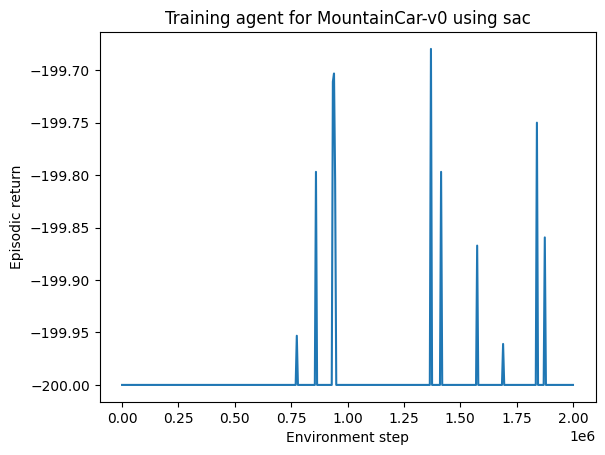

In [36]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()

In [37]:
jax.tree_util.tree_map(lambda x: x.shape, train_state).__dict__

{'rng': (2,),
 'env_state': EnvState(time=(10,), position=(10,), velocity=(10,)),
 'last_obs': (10, 2),
 'global_step': (),
 'last_done': (10,),
 'actor_ts': TrainState(step=(), apply_fn=(), params={'params': {'action_logits': {'bias': (3,), 'kernel': (64, 3)}, 'features': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x000001BE68F13CE0>, update=<function chain.<locals>.update_fn at 0x000001BE6FF69E40>), opt_state=(ScaleByAdamState(count=(), mu={'params': {'action_logits': {'bias': (3,), 'kernel': (64, 3)}, 'features': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}, nu={'params': {'action_logits': {'bias': (3,), 'kernel': (64, 3)}, 'features': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}), EmptyState())),
 'critic_ts': TrainState(step=(), apply_fn=(), param

In [38]:
policy = algo.make_act(train_state)
policy = jax.jit(policy)

In [39]:
rng = jax.random.PRNGKey(0)
env, params = gymnax.make(env_str)
step = jax.jit(env.step)

obs, state = env.reset(rng, params)
episode_return = 0
done = False

while not done:
    rng, rng_action, rng_step = jax.random.split(rng, 3)
    action = policy(obs, rng_action)
    obs, state, reward, done, info = step(rng_step, state, action, params)
    episode_return += reward

print(f"Return achieved in one episode of {env_str}: {episode_return}")

Return achieved in one episode of MountainCar-v0: -200.0


In [40]:
from RLinJAX.evaluate import evaluate

num_seeds = 50_000
max_steps = params.max_steps_in_episode

rng = jax.random.PRNGKey(0)

start = time.time()

# Evaluation time!
episode_lengths, episode_returns = evaluate(policy, rng, env, params, num_seeds, max_steps)

time_elapsed = time.time() - start

print(
    f"Evaluated {num_seeds} episodes "
    f"with a total of {jax.numpy.sum(episode_lengths)} environment steps "
    f"in {time_elapsed:g} seconds."
)

Evaluated 50000 episodes with a total of 9999927 environment steps in 1.64704 seconds.


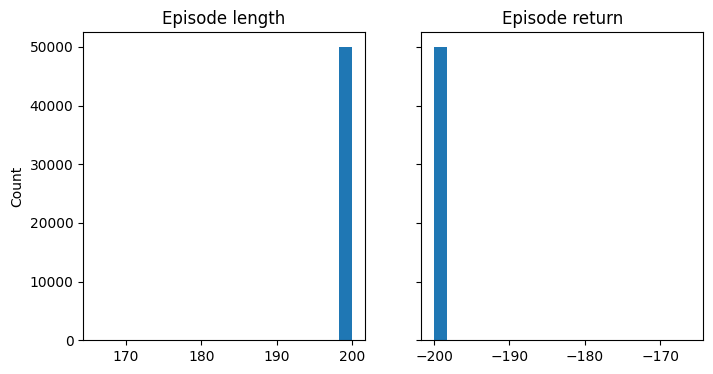

In [41]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharey="row")

plt.title("Evaluation for (our) best policy")
axes[0].hist(episode_lengths, bins=20)
axes[0].set(title="Episode length", ylabel="Count")
# axes[0].set_xticks(range(100, 210, 10))
axes[1].hist(episode_returns, bins=20)
axes[1].set(title="Episode return")
plt.show()
# axes[1].set_xticks(range(-200, -90, 10))

In [42]:

# Define thresholds for "shorter episodes" and "higher rewards"
short_episode_threshold = 125  # Episodes shorter than 125 steps
high_reward_threshold = -125  # Rewards higher than -125

# Calculate percentages
total_episodes = len(episode_lengths)
short_episodes_count = np.sum(episode_lengths < short_episode_threshold)
high_rewards_count = np.sum(episode_returns > high_reward_threshold)

short_episodes_percentage = (short_episodes_count / total_episodes) * 100
high_rewards_percentage = (high_rewards_count / total_episodes) * 100

print('Short episodes percentage',short_episodes_percentage, '%')
print('High rewards percentage',high_rewards_percentage,"%")


Short episodes percentage 0.0 %
High rewards percentage 0.0 %


In [43]:
# Calculate average returns
average_return = np.mean(episode_returns)

# Calculate the standard deviation of returns
std_deviation = np.std(episode_returns)

# Count the occurrences of each return value as percentages
unique_returns, return_counts = np.unique(episode_returns, return_counts=True)
return_percentages = (return_counts / len(episode_returns)) * 100


print(f"Average return and Standard deviation: {average_return} +/- {std_deviation}")

Average return and Standard deviation: -199.99853515625 +/- 0.18862095475196838


### 4. Discussion
---

#### 4.1 Q-learning
As seen in the theory, **Q-learning** is a reinforcement learning algorithm that learns by interacting with the environment. After performing an action in a specific state, the agent receives a reward and observes the new state it is in. It uses this information to update the values in the Q-table, eventually arriving at optimal values, but it will take some time, depending on the number of actions and states it has. 

In this project, we tackled a continuous environment, which inherently involves an infinite number of possible states., which can be further divided into speed and position. To make this problem computationally feasible, we discretized the state space into bins. The number of bins determines how finely the state space is represented: fewer bins result in worse variable representations, while more bins increase computational demands. After testing various configurations, we chose bins=10, as it struck a balance between computational efficiency and representational accuracy. This choice allowed the algorithm to converge while keeping the computational requirements manageable. 

Another critical parameter was the learning rate, since we needed to choose a value that was low enough to ensure stability and is cautious, but high enough that is able to eventually converge. Through experimentation, we found that learning_rate=0.05 was optimal, providing a balance between stability and convergence speed. With this setup, the agent achieved an average episode reward of approximately -250 after stabilization.

With this values we were able to obtain test rewards of around -250 when it stabilized. However the cart wasn't always able to reach the flag in less than 200 steps, only 37.284 % of times it was able to reach it in 200 steps. It takes around 10 0000 episodes to achieve a optimal Q-table and converge, stabilizing the rewards values, which led to a high mean and standard deviation (-3508.36 +/- 13906.53), even though we had a high count of reward values around -200 as we can see in the histogram. We also obtained low values for short episodes percentage (0.438 %), and high rewards percentage (0.438 %). Achieving better performance would likely require adjusting the parameters (e.g., increasing bins or tuning the learning rate further). 

However, with the current setup, training the Q-learning algorithm took approximately 2 hours, highlighting the computational intensity. While more aggressive parameter choices might improve performance, the computational cost would likely become prohibitive.

---

#### 4.2 Deep Q-learning
At first, we implemented the **Deep Q-learning** algorithm with the default configurations, as illustrated in the initial algo.config. Although the agent was able to function, it had difficulty learning efficiently, with returns stabilizing at approximately -200 (the minimum possible return). This underscored the necessity for parameter adjustment, since the default configuration limited exploration and did not ensure training stability. 

The initial significant change involved raising gradually the total_timesteps to 1,000,000, which gave the agent additional chances to investigate the environment and enhance its policy. Although this enhanced learning, it also lengthened training times, especially on local devices, emphasizing the unreliability of just increasing this parameter. 

The gamma value was established at 0.99, highlighting the importance of long-term rewards, which is essential for MountainCar's multi-step planning. Furthermore, we increased the buffer_size to 250,000, enabling the agent to retain a wider variety of transitions. This avoided overfitting to recent events and allowed for improved generalization. The batch size was raised to 256, which helped stabilize gradient updates by sampling a wider range of experiences. Nevertheless, these adjustments also raised computational expenses, necessitating a balance between performance and efficiency. 

We modified the target_update_freq to 800, reducing the speed of updates to the target network. This ensured stable learning by lowering the rate of changes to the Q-value targets, tackling the "moving target" issue. 

Exploration was essential for this assignment. The exploration_fraction was adjusted to 0.6, allowing the agent additional time for exploration prior to exploitation. This guaranteed enough exploration to prevent suboptimal policies. Setting eps_end to 0.05 allowed for continued exploration during the final stages of training, assisting the agent in adjusting to the challenging dynamics of MountainCar. We discovered that these exploration parameters are some of the most significant, where lower values result in overly greedy actions and higher values induce too much randomness. 

The learning rate was varied from 0.0001 to 0.01, but extreme values either hindered learning or made it unstable. The default value of 0.0003 worked well in combination with the tuned parameters.

A significant obstacle was reproducibility. Executing the same parameters on our different pcs and  Colab through different sessions and GPUs frequently yielded inconsistent outcomes. We believe this was caused by randomness in the environment and the starting values of network weights, both of which are intrinsic to deep reinforcement learning. Nonetheless, the majority of runs produced reliable learning results with the chosen parameters, enhancing our trust in their effectiveness. 

Although these parameters successfully addressed the task, we acknowledge that they might not be completely optimized.  [Online forums](reddit.com/r/reinforcementlearning/comments/emb02o/new_to_rl_and_looking_for_help_to_solve_mountain/)  indicate that solutions may be found in as little as 150,000 timesteps, possibly attainable through various tools or other sophisticated methods. Additional adjustments, particularly with platforms such as TensorFlow, may potentially produce even more favorable outcomes.

Unlike in Q-learning, the training graph did not converge. our objective was to mimic the results obtained in Q-learning as much as possible but was not 100% achievable. As said previously the stochasticity involved in deep reinforcment learning could of hindered that objective of total convergence of the training graph. Nonetheless the multiple evaluation of the policy said a different story.

From the histograms depicting the evaluation of DQN, we can see that the agent accomplishes the task in shorter episode lengths or fewer steps, which indicates greater total rewards obtained. Indeed, if we look at a brief episode length or a high-reward episode, we find that the agent performs the correct actions 99% of the time across 50,000 episodes. 

To provide a stronger explanation, we chose to examine the average reward (or the length inversely) along with the standard deviation. We find that the values fall between -108.3 +/- 7.5. The low standard deviation indicates considerable stability when implementing this optimal policy, particularly when we consider the randomness in the environment. 


In summary, the chosen parameters for DQN offered a dependable solution to MountainCar, striking a balance between exploration, stability, and computational expense. Nonetheless, there is still potential for enhancement, particularly in refining training efficiency and reproducibility. 

---



#### 4.3 Soft Actor-Critic

In this project, the **Soft Actor-Critic** algorithm did not successfully learn the task, despite testing various hyperparameters, such as the target entropy ratio, learning rate, and parameters related to the network. The absence of performance enhancement across episodes and timesteps suggests potential issues in the implementation or mismatched assumptions about the task.


We raised the total steps into the tens of millions and enlarged the replay buffer size to hold millions of transitions. However, the agent's reward consistently stabilized at approximately -199, signifying that the agent was not enhancing its policy. To tackle this, we tried various learning rates, examining values as high as 0.1 to force the agent to adjust its parameters more assertively. Although higher learning rates may speed up convergence, they can also threaten the stability of training. In this instance, though, no significant enhancement was noted.

Regarding the target entropy ratio, we tested values ranging from 0.5 to 1. This parameter governs the agent's level of uncertainty by controlling how much exploration is incentivized. In theory, this setting is particularly useful in environments like MountainCar, where significant exploration is required to discover the optimal strategy. Once again, none of these adjustments resulted in any improvement, as the agent consistently failed to learn an effective policy and remained stuck near -199 returns. This issue persisted across multiple machines and Colab sessions, ruling out hardware-related inconsistencies.


A major difficulty in debugging SAC is the built-in "black box" characteristic of deep reinforcement learning algorithms. In contrast to more straightforward algorithms like Q-learning, SAC depends on deep neural networks and intricate objectives, which complicates the extraction of understandable insights regarding the training process. Important diagnostics, like examining Q-value estimates, policy entropy, or gradients, could offer valuable insights but we weren´t able to extract those.



In the end, although we did not succeed in achieving effective learning with SAC for this task, the project provided significant insights into the workings and difficulties of the algorithm. This includes its responsiveness to hyperparameters and the significance of debugging tools in comprehending deep RL models. Although it wasn't successful, this experience fosters curiosity    for future research into SAC and other sophisticated reinforcement learning methods. 









 

















### 5. Conclusion
---

We managed to achieve learning of the task using Q learning and Deep Q learning. Unfortunelty it was not possible to complete the goal using Soft Actor Critic.

While using Q learning, the agents training, managed to converge on high rewards. However, using this technique, proved to be extremely computationally expensive, taking around 2 hours to run. Even though Q-learning was a relatively more extensive  to implement, because it was done from scratch, unlike DQN and SAC, it was easier to undertand any problem with the hyperparameters or the model, when running the code. DQN and SAC, were basically black boxes, and we could only rely on trial and error to debug them trough hyperparameter tuning.

Then, implementing DQN, was much easier, as we only had to play around with the parameters of the model. After a few changes we managed to get a similar histogram for evaluation, like we got in Q learning, which validated even more the results. Unfortunatly we could not mimic the convergence found in the training of the agent in DQN. This can possibly make the results less reliable than those obtained trough Q learning. Nonetheless, as we ran the model multiple times, on multiple machines, we got a majority of the time the expected results, on those parameters.

Finally, when approaching the task trough SAC, it involved similarly to DQN, hyperparameter tuning. However, despite many trials, we could not find a set of parameters that enabled learning of the agent. And as said previously, the black box effect difficulted even more our understanding of issues that could be going on.

In conclusion, we believe that the objective of this second project in the course was completed, even though we are aware that many more optimizations to our work could have been done, especially in the last algorithm implmented.

